Author: Luca Pappalardo
</br>Geospatial Analytics, Master degree in Data Science and Business Informatics, University of Pisa

# Geospatial Analytics - Lesson 5: Mobility laws and models
- Individual measures
    1. [Jump length](#jumplength)
    2. [Max distance](#maxdistance)
    3. [Distance straight line](#straightline)
    4. [Max distance from home](#distfromhome)
    5. [Radius of gyration](#rg)
    6. [$k$-radius of gyration](#krg)
    7. [Location Frequency](#locfreq)
    8. [Uncorrelated entropy](#uncentropy)
    9. [Individual mobility network](#IMN)
- Collective measures
    1. [Visits per location](#visits_per_location)
    2. [Homes per location](#homes_per_location)
    3. [Visits per time unit](#visits_per_time_unit)
- [Mobility models](#models)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the library
import skmob
import pandas as pd
from tqdm import tqdm
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from stats_utils import *
from skmob.utils.plot import *
from skmob.data.load import *
from skmob.tessellation.tilers import tiler

## Measures
We can compute on a `TrajDataFrame` two types of measures:

- *individual measures*, describing features related to the mobility patterns of a single individual
- *collective measures*, describing the mobility patterns of an entire population of individuals

## Loading the data
We load data of checkins made by users on Brightkite, a location-based social network (LBSN).

The dataset is freely available at the SNAP website: https://snap.stanford.edu/data/loc-brightkite.html

In [3]:
# download the dataset using pandas
url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
df = pd.read_csv(url, sep='\t', header=0, nrows=1000000, 
                 names=['user', 'check-in_time', "latitude", "longitude", 
                        "location id"])
df.head()

,user,check-in_time,latitude,longitude,location id
0,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
3,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
4,0,2010-10-13T23:31:51Z,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907


In [4]:
# convert the pandas DataFrame into an skmob TrajDataFrame
tdf = skmob.TrajDataFrame(df, latitude='latitude', 
            longitude='longitude', datetime='check-in_time', user_id='user')
print(tdf.shape)
tdf.head()

(1000000, 5)


,uid,datetime,lat,lng,location id
0,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
3,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
4,0,2010-10-13 23:31:51+00:00,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907


In [5]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 2757
number of records:	 1000000


In [6]:
plot_points_heatmap(tdf, map_f=None, max_points=1000, 
                        tiles='cartodbpositron', zoom=2,
                       min_opacity=0.5, radius=25, blur=15,
                       gradient=None);

## Individual measures
Computed on the trajectories, quantify standard mobility patterns.

<a id='jumplength'></a>
### Jump lengths
- a jump length is the distance between two consecutive visits of an individual
- given a `TrajDataFrame`, skmob computes the lengths for each individual independently
- use the `jump_lengths` function

In [7]:
from skmob.measures.individual import jump_lengths

In [8]:
jl_df = jump_lengths(tdf) # disable progress bar with show_progress=False
jl_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:06<00:00, 404.34it/s]


,uid,jump_lengths
0,0,"[19.64046732887831, 0.0, 0.0, 1.74343110103816..."
1,1,"[6.505330424378811, 46.754366003759536, 53.928..."
2,2,"[0.0, 0.0, 0.0, 0.0, 3.641009719594163, 0.0, 5..."
3,3,"[3861.270630079885, 4.061631313492122, 5.91632..."
4,4,"[15511.92758595804, 0.0, 15511.92758595804, 1...."


In [9]:
# merge=True put all distances of the individuals into a single list
jl_list = jump_lengths(tdf, merge=True)

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:07<00:00, 375.58it/s]


In [10]:
type(jl_list)

list

In [11]:
len(jl_list)

997243

In [12]:
jl_list[:10]

[19.64046732887831,
 0.0,
 0.0,
 1.743431101038163,
 1553.5011134765616,
 0.0,
 30.14517724008101,
 0.0,
 2.563647571198179,
 1.9309489380903868]

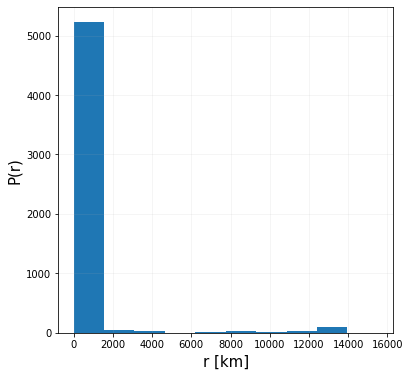

In [13]:
# let's plot the distribution of jump lengths
fig = plt.figure(figsize=(6, 6))
d_list = [dist for dist in jl_list[:10000] if dist >= 1]
plt.hist(d_list)
plt.xlabel('r [km]', fontsize=15)
plt.ylabel('P(r)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

In [14]:
x, y = zip(*lbpdf(1.5, [r for r in jl_list if r > 1.0]))

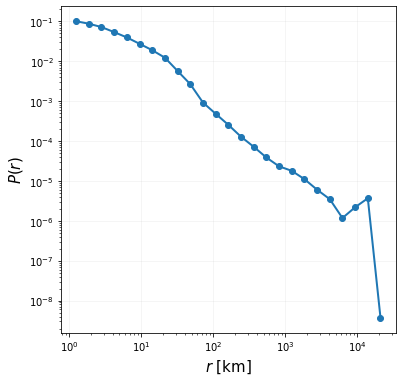

In [15]:
# let's plot the distribution of jump lengths
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('$r$ [km]', fontsize=15)
plt.ylabel('$P(r)$', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="maxdistance"></a>
### Max distance
- maximum distance traveled by each individual 
- use function `maximum_distance`

In [16]:
from skmob.measures.individual import maximum_distance

In [17]:
md_df = maximum_distance(tdf)
md_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:06<00:00, 409.10it/s]


,uid,maximum_distance
0,0,11294.436420
1,1,12804.895064
2,2,11286.745660
3,3,12803.259219
4,4,15511.927586


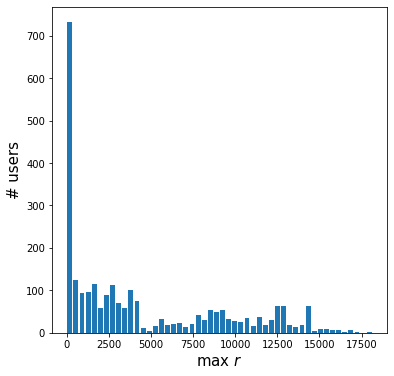

In [18]:
# let's plot the distribution
fig = plt.figure(figsize=(6, 6))
plt.hist(md_df['maximum_distance'], bins=50, rwidth=0.8)
plt.xlabel('max $r$', fontsize=15)
plt.ylabel('# users', fontsize=15)
plt.show()

In [19]:
md_df = md_df[md_df['maximum_distance'] > 1]

In [20]:
x, y = zip(*lbpdf(1.5, list(md_df['maximum_distance'])))

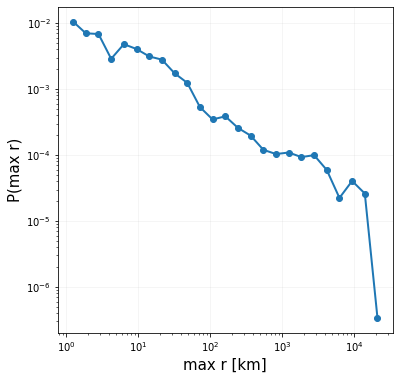

In [21]:
# let's plot the distribution of max distance
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('max r [km]', fontsize=15)
plt.ylabel('P(max r)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="straightline"></a>
### Distance straight line
- distance straight line traveled by each individual
- use function `distance_straight_line`

In [22]:
from skmob.measures.individual import distance_straight_line

In [23]:
dsl_df = distance_straight_line(tdf)
dsl_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:06<00:00, 406.06it/s]


,uid,distance_straight_line
0,0,374530.954882
1,1,774346.816009
2,2,88710.682464
3,3,470986.771764
4,4,214623.524252


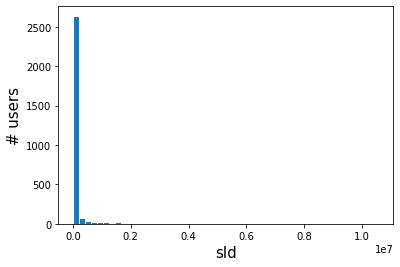

In [24]:
# let's plot the distribution
fig = plt.figure()
plt.hist(dsl_df['distance_straight_line'], bins=50, rwidth=0.8)
plt.xlabel('sld', fontsize=15)
plt.ylabel('# users', fontsize=15)
plt.show()

In [25]:
dsl_df = dsl_df[dsl_df['distance_straight_line'] > 1]

In [26]:
x, y = zip(*lbpdf(1.5, list(dsl_df['distance_straight_line'])))

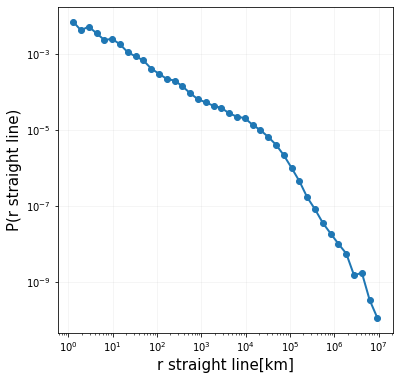

In [27]:
# let's plot the distribution 
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('r straight line[km]', fontsize=15)
plt.ylabel('P(r straight line)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="distfromhome"></a>
### Max distance from home
- compute the maximum distance traveled by an individual from their home
- use the function `max_distance_from_home`

In [28]:
from skmob.measures.individual import max_distance_from_home

In [29]:
mdh_df = max_distance_from_home(tdf)
mdh_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:16<00:00, 168.94it/s]


,uid,max_distance_from_home
0,0,11286.942949
1,1,12800.547682
2,2,11282.748348
3,3,12799.754644
4,4,15512.788707


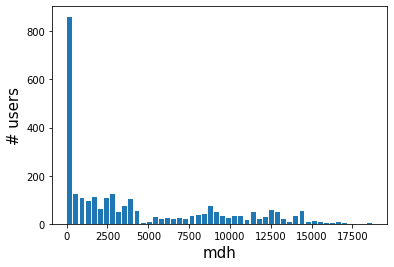

In [30]:
# let's plot the distribution
fig = plt.figure()
plt.hist(mdh_df['max_distance_from_home'], bins=50, rwidth=0.8)
plt.xlabel('mdh', fontsize=15)
plt.ylabel('# users', fontsize=15)
plt.show()

In [31]:
mdh_df = mdh_df[mdh_df['max_distance_from_home'] > 1]

In [32]:
x, y = zip(*lbpdf(1.5, list(mdh_df['max_distance_from_home'])))

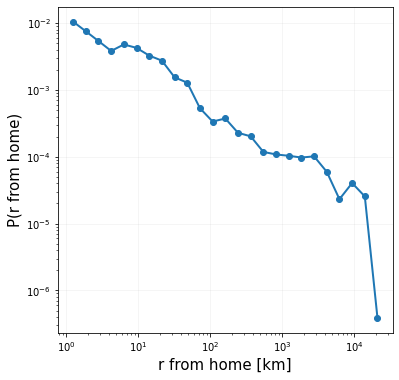

In [33]:
# let's plot the distribution 
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('r from home [km]', fontsize=15)
plt.ylabel('P(r from home)', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="rg"></a>
### Radius of gyration $r_g$
characteristic distance traveled by an individual:

$$r_g = \sqrt{\frac{1}{N} \sum_{i=1}^N (\mathbf{r}_i - \mathbf{r}_{cm})^2}$$

$r_{cm}$ is the position vector of the center of mass of the set of locations visited by the individual

In [34]:
from skmob.measures.individual import radius_of_gyration

In [35]:
rg_df = radius_of_gyration(tdf)
rg_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:05<00:00, 460.39it/s]


,uid,radius_of_gyration
0,0,1564.436792
1,1,2467.773523
2,2,1439.649774
3,3,1752.604191
4,4,5380.503250


In [36]:
type(rg_df)

pandas.core.frame.DataFrame

<AxesSubplot:ylabel='Frequency'>

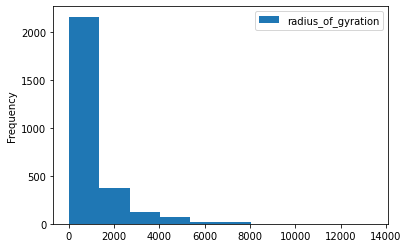

In [37]:
rg_df.plot(kind='hist', y='radius_of_gyration')

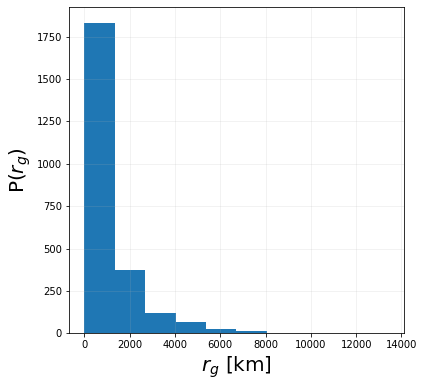

In [38]:
# let's plot the distribution
fig = plt.figure(figsize=(6, 6))
rg_list = list(rg_df.radius_of_gyration[rg_df.radius_of_gyration >= 1.0])
plt.hist(rg_list)
plt.xlabel('$r_g$ [km]', fontsize=20);plt.ylabel('P($r_g$)', fontsize=20)
plt.grid(alpha=0.2)
plt.show()

In [39]:
rg_df = rg_df[rg_df['radius_of_gyration'] > 1]

In [40]:
x, y = zip(*lbpdf(1.5, list(rg_df['radius_of_gyration'])))

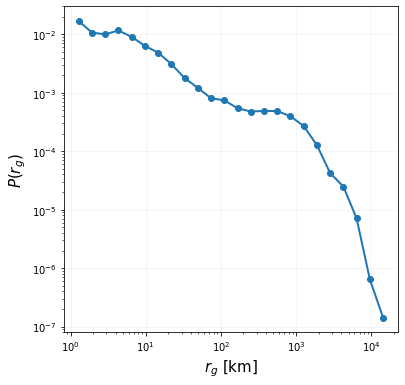

In [41]:
# let's plot the distribution
fig = plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='o', linewidth=2)
plt.loglog()
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$P(r_g)$', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

<a id="krg"></a>
### $k$-radius of gyration $r_g^{(k)}$
recurrent distance traveled by an individual:

$$r_g^{(k)} = \sqrt{\frac{1}{N_k} \sum_{i=1}^k (\mathbf{r}_i - \mathbf{r}_{cm}^{(k)})^2}$$

$r_{cm}^{(k)}$ is the position vector of the center of mass of the set $k$ most visited locations

In [42]:
from skmob.measures.individual import k_radius_of_gyration

In [43]:
krg_df = k_radius_of_gyration(tdf, k=2)

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:11<00:00, 244.16it/s]


In [44]:
krg_df.head()

,uid,2k_radius_of_gyration
0,0,7.858833
1,1,4.069300
2,2,5.878727
3,3,10.622092
4,4,0.740360


In [45]:
rgs_df = pd.merge(rg_df, krg_df, on='uid')
rgs_df.head()

,uid,radius_of_gyration,2k_radius_of_gyration
0,0,1564.436792,7.858833
1,1,2467.773523,4.069300
2,2,1439.649774,5.878727
3,3,1752.604191,10.622092
4,4,5380.503250,0.740360


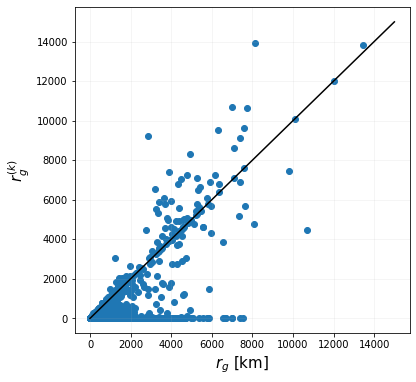

In [46]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(rgs_df['radius_of_gyration'], rgs_df['2k_radius_of_gyration'], marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.plot([0, 15000], [0, 15000], color="black")
plt.show()

<a id='locfreq'></a>
### Location frequency
- compute the frequency of visiting each location
- use the function `location_frequency`

In [47]:
from skmob.measures.individual import location_frequency

In [48]:
lf_df = location_frequency(tdf, normalize=True).reset_index()
lf_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:04<00:00, 629.60it/s]


,uid,lat,lng,location_frequency
0,0,39.762146,-104.982480,0.101953
1,0,39.891077,-105.068532,0.065269
2,0,39.739154,-104.984703,0.060029
3,0,39.891586,-105.068463,0.034302
4,0,39.827022,-105.143191,0.025250


In [49]:
a_user_lf_df = lf_df[lf_df['uid'] == 1]
a_user_lf_df.head()

,uid,lat,lng,location_frequency
542,1,37.630490,-122.411084,0.245455
543,1,37.580304,-122.343679,0.222314
544,1,37.584103,-122.366083,0.205785
545,1,37.613825,-122.486919,0.041322
546,1,0.000000,0.000000,0.038017


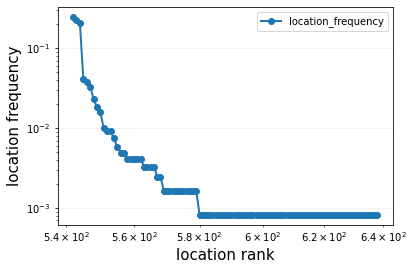

In [50]:
a_user_lf_df.plot(y='location_frequency', linewidth=2, marker='o')
plt.loglog()
plt.xlabel('location rank', fontsize=15)
plt.ylabel('location frequency', fontsize=15)
plt.grid(alpha=0.2)
plt.show()

In [51]:
new_lf_df = location_frequency(tdf, as_ranks=True)
type(new_lf_df)

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:04<00:00, 638.49it/s]


list

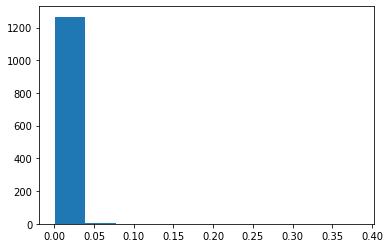

In [52]:
plt.hist(new_lf_df)
plt.show()

<a id="uncentropy"></a>
### Uncorrelated entropy

The predictability of an individual considering the spatial dimension only:

$$ S^{unc} = - \sum_{i=1}^N p_i \log_2(p_i)$$

In [53]:
from skmob.measures.individual import uncorrelated_entropy

In [54]:
s_unc_df = uncorrelated_entropy(tdf, normalize=True)
s_unc_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:06<00:00, 415.68it/s]


,uid,norm_uncorrelated_entropy
0,0,0.819430
1,1,0.552972
2,2,0.764304
3,3,0.794553
4,4,0.756421


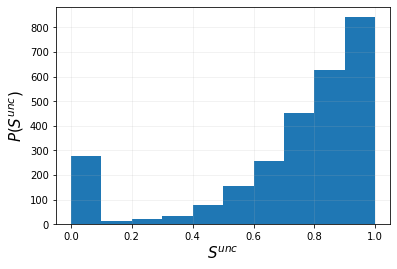

In [55]:
plt.hist(s_unc_df['norm_uncorrelated_entropy'])
plt.xlabel('$S^{unc}$', fontsize=15)
plt.ylabel('$P(S^{unc})$', fontsize=15)
plt.grid(alpha=0.2)
plt.show()

<a id="IMN"></a>
### Individual mobility network
it is a network where:

- nodes represent locations visited by the individual
- directed edges represent trips between the locations made by the individual

In [56]:
from skmob.measures.individual import individual_mobility_network

In [57]:
imn_df = individual_mobility_network(tdf)
imn_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:06<00:00, 408.66it/s]


,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
0,0,37.774929,-122.419415,37.600747,-122.382376,1
1,0,37.600747,-122.382376,37.615223,-122.389979,1
2,0,37.600747,-122.382376,37.580304,-122.343679,1
3,0,37.615223,-122.389979,39.878664,-104.682105,1
4,0,37.615223,-122.389979,37.580304,-122.343679,1


In [58]:
an_imn = imn_df[imn_df.uid == 2]
an_imn.sort_values(by='n_trips', ascending=False).head()

,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
1686,2,39.758302,-104.936129,39.802002,-105.09543,69
1452,2,39.802002,-105.09543,39.758302,-104.936129,59
1493,2,39.739154,-104.984703,39.802002,-105.09543,52
1446,2,39.802002,-105.09543,39.739154,-104.984703,51
1535,2,39.739154,-104.984703,39.81804,-105.081949,23


In [59]:
import networkx as nx
from tqdm import tqdm

In [60]:
a_user_imn_df = imn_df[imn_df['uid'] == 3]
print(len(a_user_imn_df))
a_user_imn_df.head()

1054


,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
2413,3,29.894691,-81.314517,37.758839,-122.388345,1
2414,3,29.894691,-81.314517,29.800407,-81.319127,1
2415,3,37.758839,-122.388345,37.795105,-122.393861,1
2416,3,37.795105,-122.393861,37.752539,-122.434248,1
2417,3,37.795105,-122.393861,37.806327,-122.405041,1


In [61]:
g = nx.DiGraph()

In [62]:
for i, row in a_user_imn_df.iterrows():
    origin = (row['lat_origin'], row['lng_origin'])
    destination = (row['lat_dest'], row['lng_dest'])
    g.add_edge(origin, destination, weight=row['n_trips'])

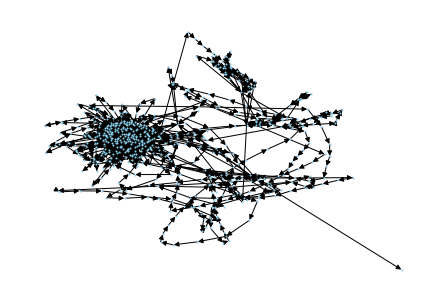

In [63]:
nx.draw(g, node_size=1, node_color="skyblue")

You may custommize the visualization of the network: https://www.python-graph-gallery.com/321-custom-networkx-graph-appearance

## Collective measures
are computed on the trajectories of all individual together and quantify standard collective mobility patterns

<a id="visits_per_location"></a>
### Visits per location
number of visits to a location made by the population of individuals

In [64]:
from skmob.measures.collective import visits_per_location

In [65]:
vpl_df = visits_per_location(tdf)
vpl_df.head()

,lat,lng,n_visits
0,0.000000,0.000000,20397
1,39.739154,-104.984703,11949
2,40.014986,-105.270546,5893
3,37.774929,-122.419415,4993
4,40.714269,-74.005973,3626


Text(0.5, 0, 'number of visits')

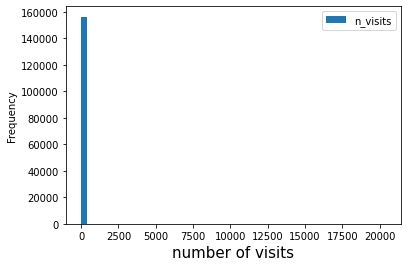

In [66]:
vpl_df.plot(kind='hist', y='n_visits', bins=50)
plt.xlabel('number of visits', fontsize=15)

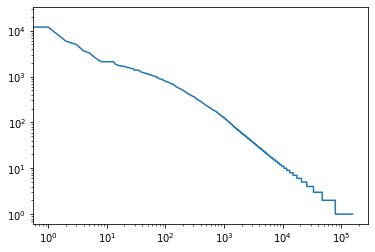

In [67]:
vpl_df['n_visits'].plot()
plt.loglog()
plt.show()

<a id="homes_per_location"></a>
### Homes per location
Compute the number of home locations in each location 

In [68]:
from skmob.measures.collective import homes_per_location

In [69]:
hpl_df = homes_per_location(tdf)
hpl_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:05<00:00, 471.25it/s]


,lat,lng,n_homes
0,39.739154,-104.984703,99
1,40.014986,-105.270546,51
2,37.774929,-122.419415,46
3,0.000000,0.000000,44
4,30.267153,-97.743061,23


<AxesSubplot:ylabel='Frequency'>

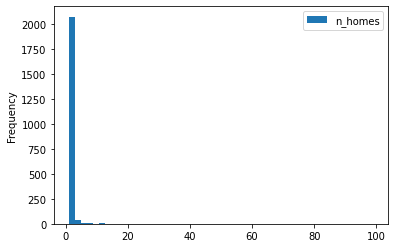

In [70]:
hpl_df.plot(kind='hist', y='n_homes', bins=50)

<a id="visits_per_time_unit"></a>
### Visits per time unit

In [71]:
from skmob.measures.collective import visits_per_time_unit

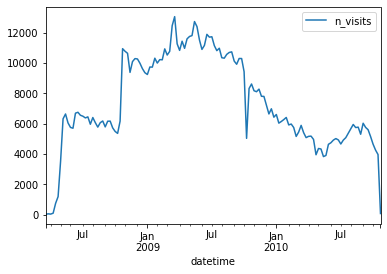

In [72]:
visits_per_time_unit(tdf, time_unit='1w').plot()
plt.show()

<a id="models"></a>
## Mobility models

We want to simulate the mobility of **500** individuals moving in **New York City** for **30 days** with four different generative models:
1. Density-EPR (d-epr)
2. Spatial-EPR (s-epr)
3. Ditras
4. STS-EPR

In [73]:
# set the dates to simulates 30 days

start = pd.to_datetime('2022/10/01 00:00:00')
end = pd.to_datetime('2022/10/30 00:00:00')

In [74]:
# get a tessellation of NYC

tessellation = tiler.get("squared", base_shape="New York City", meters=3000)

Load real mobility traces of people moving in New York City

In [75]:
%%time

tdf_nyc = tdf.mapping(tessellation, remove_na=True)

Wall time: 48 s


In [76]:
plot_points_heatmap(tdf_nyc, map_f=None, zoom=8, radius=25, blur=15)

**Weighted tessellation** <br>
We map each point with the corresponding tile to compute a weighted tessellation at each tile is associated its relevance, namely the popularity of a location among real individuals. The overall number of visits to a location is usually used as an estimation of its relevance.

In [77]:
visits_per_tile = tdf_nyc.groupby("tile_ID", as_index=False).count()
visits_per_tile = visits_per_tile[["tile_ID", "uid"]]
visits_per_tile["relevance"] = visits_per_tile["uid"]
visits_per_tile = visits_per_tile[["tile_ID", "relevance"]]
visits_per_tile.head()

,tile_ID,relevance
0,10,1
1,100,17
2,101,742
3,102,434
4,103,393


In [78]:
weighted_tessellation = tessellation.set_index("tile_ID").join(visits_per_tile.set_index("tile_ID"))
weighted_tessellation = weighted_tessellation.fillna(0)

weighted_tessellation_pos = weighted_tessellation[weighted_tessellation["relevance"]>0]

weighted_tessellation_pos[6:11]

,geometry,relevance
tile_ID,,
42,"POLYGON ((-74.12410 40.55853, -74.12410 40.579...",5.0
44,"POLYGON ((-74.12410 40.59946, -74.12410 40.619...",3.0
46,"POLYGON ((-74.12410 40.64038, -74.12410 40.660...",1.0
50,"POLYGON ((-74.09715 40.55853, -74.09715 40.579...",1.0
51,"POLYGON ((-74.09715 40.57900, -74.09715 40.599...",2.0


### The EPR model

$S$ is the number of distinct locations previously visited by the agent <br>
$\rho$ controls the agent’s tendency to explore a new location during the next (default 0.6) <br>
$\gamma$ controls the agent’s tendency to explore a new location during the next (default 0.21) <br>


<div>
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnphys1760/MediaObjects/41567_2010_Article_BFnphys1760_Fig2_HTML.jpg?as=webp" width="400"/>
</div>


### 1. Density-EPR (d-epr)


<b>exploration choice:</b> $p_{ij} = \frac{1}{N} \frac{n_i n_j}{r_{ij}^2}$  <br>
<b>return choice: $\Pi_i = f_i$</b>

$n_{i (j)}$ is the location relevance <br>
$r_{ij}$ is the geographic distance between $i$ and $j$. <br> 
$f_i$ is the visitation frequency of location $i$.

In [79]:
from skmob.models.epr import DensityEPR

depr = DensityEPR()

traj_depr = depr.generate(start, end, weighted_tessellation_pos, relevance_column='relevance', 
                          n_agents=500, show_progress=True)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:50<00:00, 10.00it/s]


### 2. Spatial-EPR (s-epr)

<b>exploration choice:</b> $p_{ij} = \frac{1}{r_{ij}^2}$  <br>
<b>return choice: $\Pi_i = f_i$</b>

$r_{ij}$ is the geographic distance between $i$ and $j$. <br> 
$f_i$ is the visitation frequency of location $i$.

In [80]:
from skmob.models.epr import SpatialEPR

sepr = SpatialEPR()

traj_sepr = sepr.generate(start, end, weighted_tessellation_pos, n_agents=500, show_progress=True)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:56<00:00,  8.81it/s]


### 3. Ditras

**Mobility Diary Generation**: In the first phase, DITRAS generates a mobility diary which captures the temporal patterns of human mobility.

**Trajectory Generation**: In the second phase, DITRAS transforms the mobility diary into a mobility trajectory which captures the spatial patterns of human movements usign the d-EPR model.


<img src="https://raw.githubusercontent.com/jonpappalord/DITRAS/master/DITRAS_schema.png" width="400"/>



In [81]:
# fit the mobility diary generator

from skmob.models.markov_diary_generator import MarkovDiaryGenerator
from skmob.preprocessing import compression, detection, clustering

ctdf = compression.compress(tdf_nyc)
stdf = detection.stay_locations(ctdf)
cstdf = clustering.cluster(stdf)

mdg_nyc = MarkovDiaryGenerator()

mdg_nyc.fit(cstdf, 500, lid="cluster")

 73%|██████████████████████████████████████████████████████████▍                     | 365/500 [01:21<00:30,  4.46it/s]


In [82]:
from skmob.models.epr import Ditras

ditras = Ditras(mdg_nyc)

traj_ditras = ditras.generate(start, end, weighted_tessellation_pos, relevance_column='relevance', n_agents=500, 
                              show_progress=True)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 82.67it/s]


### 4. STS-EPR
<div>
<img src="https://i.ibb.co/8X6strg/Cattura.png" width="800"/>
</div>


In [83]:
from skmob.models.sts_epr import STS_epr

sts_epr = STS_epr()

traj_sts = sts_epr.generate(start, end, social_graph="random", n_agents=500, rsl=True,
                                    spatial_tessellation=weighted_tessellation_pos,
                                    diary_generator=mdg_nyc, show_progress=True, relevance_column='relevance')

100%|████████████████████████████████████████████████████████████████████████████████| 696/696 [00:13<00:00, 53.28it/s]


### Analysis of the Synthetic Trajectories

In [84]:
synt_dict = {"depr": traj_depr, "sepr": traj_sepr, "ditras": traj_ditras, "sts-epr": traj_sts}

#### 1. Compare the Jump Length of synthetic and real trajectories

In [93]:
# real
jl_list_real = jump_lengths(tdf_nyc, merge=True, show_progress=False)
x_real, y_real = zip(*lbpdf(3, [r for r in jl_list_real if r > 1.0]))


# synth
jl_dist = []
for model in synt_dict:
    jl_list = jump_lengths(synt_dict[model], merge=True, show_progress=False)
    x, y = zip(*lbpdf(3, [r for r in jl_list if r > 1.0]))
    jl_dist.append((model,x,y))

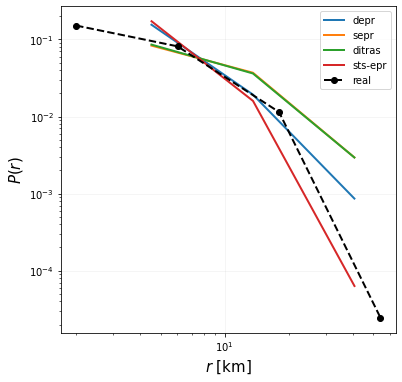

In [94]:
# let's plot the distribution of jump lengths

fig = plt.figure(figsize=(6, 6))

for m, x, y in jl_dist:
     plt.plot(x, y, linewidth=2, label=m)
        
# real
plt.plot(x_real, y_real, marker='o', linewidth=2, label="real", color="black", linestyle="dashed")
    
plt.loglog()
plt.legend()
plt.xlabel('$r$ [km]', fontsize=15)
plt.ylabel('$P(r)$', fontsize=15)
plt.grid(alpha=0.15)
plt.show()

#### 2. $k$-radius of gyration $r_g^{(k)}$ vs. radius of gyration $r_g$

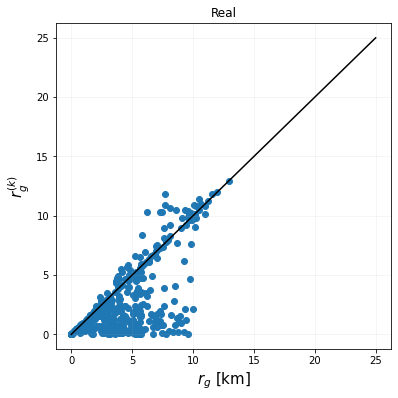

In [95]:
# compute rg and k-rg for real data

rg_real = list(radius_of_gyration(tdf_nyc, show_progress=False)["radius_of_gyration"])
k2rg_real = list(k_radius_of_gyration(tdf_nyc, k=2, show_progress=False)["2k_radius_of_gyration"])

fig = plt.figure(figsize=(6, 6))
plt.title("Real")
plt.scatter(rg_real, k2rg_real, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.plot([0, 25], [0, 25], color="black")
plt.show()

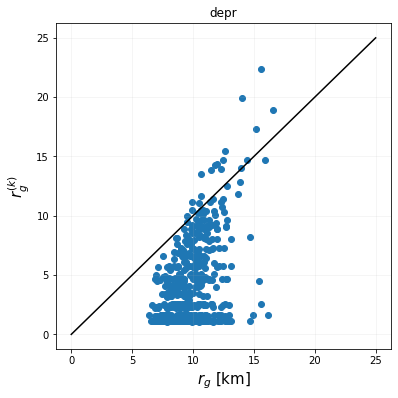

In [96]:
# compute rg and k-rg for sepr

synt_data = synt_dict["sepr"]

rg_syn = list(radius_of_gyration(synt_data, show_progress=False)["radius_of_gyration"])
k2rg_syn = list(k_radius_of_gyration(synt_data, k=2, show_progress=False)["2k_radius_of_gyration"])

fig = plt.figure(figsize=(6, 6))
plt.title("depr")
plt.scatter(rg_syn, k2rg_syn, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.plot([0, 25], [0, 25], color="black")
plt.show()

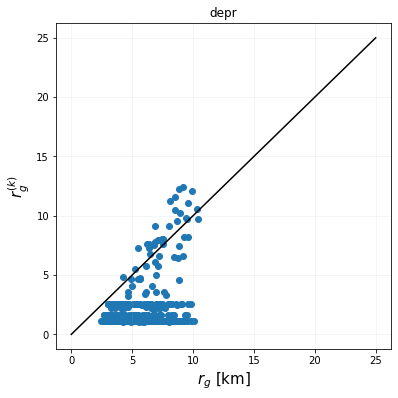

In [89]:
# compute rg and k-rg for depr

synt_data = synt_dict["depr"]

rg_syn = list(radius_of_gyration(synt_data, show_progress=False)["radius_of_gyration"])
k2rg_syn = list(k_radius_of_gyration(synt_data, k=2, show_progress=False)["2k_radius_of_gyration"])

fig = plt.figure(figsize=(6, 6))
plt.title("depr")
plt.scatter(rg_syn, k2rg_syn, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.plot([0, 25], [0, 25], color="black")
plt.show()

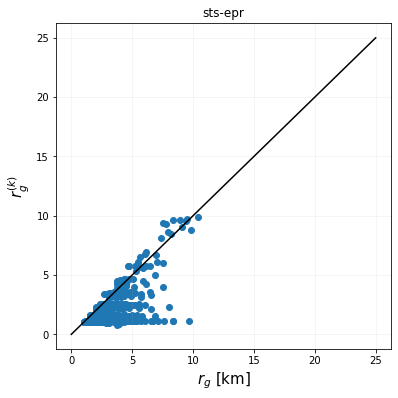

In [97]:
# compute rg and k-rg for sts-epr

synt_data = synt_dict["sts-epr"]

rg_syn = list(radius_of_gyration(synt_data, show_progress=False)["radius_of_gyration"])
k2rg_syn = list(k_radius_of_gyration(synt_data, k=2, show_progress=False)["2k_radius_of_gyration"])

fig = plt.figure(figsize=(6, 6))
plt.title("sts-epr")
plt.scatter(rg_syn, k2rg_syn, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=15)
plt.ylabel('$r_g^{(k)}$', fontsize=15)
plt.grid(alpha=0.15)
plt.plot([0, 25], [0, 25], color="black")
plt.show()